# 7 Using the PyTorch JIT Compiler with Pyro

In [1]:
import os
import torch
import pyro
import pyro.distributions as D
from torch.distributions import constraints as C
from pyro import poutine
from pyro.distributions.util import broadcast_shape
from pyro.infer import Trace_ELBO, JitTrace_ELBO, TraceEnum_ELBO, JitTraceEnum_ELBO, SVI
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

In [2]:
def model(data):
    loc = pyro.sample('loc', D.Normal(0, 10))
    scale = pyro.sample('scale', D.LogNormal(0, 3))
    with pyro.plate('data', data.size(0)):
        pyro.sample('obs', D.Normal(loc, scale), obs=data)

In [3]:
guide = AutoDiagonalNormal(model)
data = D.Normal(0.5, 2).sample((100, ))

In [4]:
%%time
pyro.clear_param_store()
elbo = Trace_ELBO()
svi = SVI(model, guide, Adam({'lr': 0.01}), elbo)
for _ in range(1000):
    svi.step(data)

CPU times: user 2.47 s, sys: 32.6 ms, total: 2.5 s
Wall time: 2.59 s


In [7]:
%%time
pyro.clear_param_store()

guide(data)

elbo = JitTrace_ELBO()
svi = SVI(model, guide, Adam({'lr': 0.01}), elbo)
for _ in range(1000):
    svi.step(data)

CPU times: user 1.36 s, sys: 70.8 ms, total: 1.43 s
Wall time: 1.6 s


In [8]:
%%time 
nuts = NUTS(model)
pyro.set_rng_seed(1)
mcmc_run = MCMC(nuts, num_samples=100).run(data)

Sample: 100%|██████████| 200/200 [00:01, 123.05it/s, step size=1.16e+00, acc. prob=0.905]

CPU times: user 1.58 s, sys: 44.1 ms, total: 1.62 s
Wall time: 1.7 s


In [9]:
%%time 
nuts = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
pyro.set_rng_seed(1)
mcmc_run = MCMC(nuts, num_samples=100).run(data)

Sample: 100%|██████████| 200/200 [00:01, 189.07it/s, step size=1.27e+00, acc. prob=0.876]

CPU times: user 1.03 s, sys: 25.3 ms, total: 1.06 s
Wall time: 1.07 s


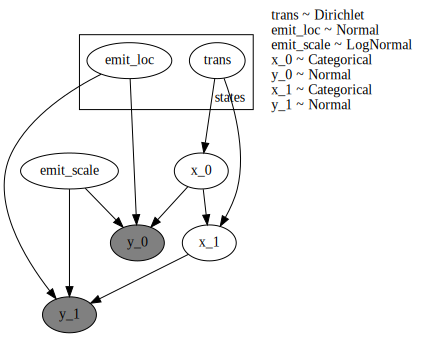

In [26]:
def model(sequence, num_sequences, length, state_dim=16):
    # Gaussian HMM 
    with pyro.plate('states', state_dim):
        trans = pyro.sample('trans', D.Dirichlet(0.5 * torch.ones(state_dim)))
        emit_loc = pyro.sample('emit_loc', D.Normal(0, 10))
    emit_scale = pyro.sample('emit_scale', D.LogNormal(0, 3))
    
    
    with poutine.scale(scale=num_sequences):
        x = 0
        for t in pyro.markov(range(length)):
            x = pyro.sample(f'x_{t}', D.Categorical(trans[x]), infer={"enumerate": "parallel"})
            pyro.sample(f'y_{t}', D.Normal(emit_loc[x], emit_scale), obs=sequence[t])
            
seq = torch.randn(2)

pyro.render_model(model, (seq, 1, 2), render_distributions=True)

In [27]:
lengths = [24] * 50 + [48] * 20 + [72] * 5
sequences = [torch.randn(length) for length in lengths]

guide = AutoDiagonalNormal(poutine.block(model, expose=['trans', 'emit_scale', 'emit_loc']))

In [28]:
%%time
pyro.clear_param_store()
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, Adam({'lr': 1e-2}), elbo)
for _ in range(10):
    for seq in sequences:
        svi.step(seq, num_sequences=len(sequences), length=len(seq))

CPU times: user 2min 57s, sys: 2.17 s, total: 2min 59s
Wall time: 46.8 s


In [29]:
%%time
pyro.clear_param_store()

guide(sequences[0], num_sequences=len(sequences), length=len(sequences[0]))

elbo = JitTraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, Adam({'lr': 1e-2}), elbo)
for _ in range(10):
    for seq in sequences:
        svi.step(seq, num_sequences=len(sequences), length=len(seq))

CPU times: user 3min 29s, sys: 3.94 s, total: 3min 33s
Wall time: 1min 29s
